# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [3]:
default_seed = 1
output_file = "output_sample"

In [4]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [5]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [6]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = False
data["outcome"][data["loan_status"]=="Default"]=True
data["outcome"][data["loan_status"]=="Charged Off"]=True

In [7]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [8]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice([True, False], len(data), p=[0.7, 0.3])

In [9]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

In [10]:
data

,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,last_pymnt_d,loan_length,term_num,ret_PESS,ret_OPT,ret_INTa,ret_INTb,outcome,cr_hist,train
3,90723253,7000.0,7000.0,36 months,10.99,229.14,B,< 1 year,MORTGAGE,38000.00,...,2017-12-01,14.981827,36,0.034821,0.083572,0.045087,0.086364,False,238.000780,True
7,90118352,3000.0,3000.0,36 months,13.99,102.52,C,10+ years,MORTGAGE,56000.00,...,2017-03-01,5.946734,36,-0.218896,-0.218896,-0.123326,-0.109557,True,156.027845,False
8,90230102,17000.0,17000.0,36 months,14.49,585.08,C,5 years,RENT,54000.00,...,2018-02-01,17.018830,36,0.052929,0.112086,0.056631,0.098974,False,59.040227,True
11,90721351,30000.0,30000.0,36 months,10.99,982.02,B,2 years,RENT,80000.00,...,2017-01-01,4.008296,36,0.011718,0.105466,0.032237,0.075798,False,204.028830,True
12,90106576,32200.0,32200.0,60 months,21.49,880.02,D,10+ years,MORTGAGE,65000.00,...,2017-04-01,6.965235,60,0.022179,0.190105,0.048484,0.093781,False,286.001766,True
13,90581844,1000.0,1000.0,36 months,13.49,33.94,C,10+ years,OWN,65000.00,...,2017-07-01,9.955030,36,0.030081,0.108293,0.043137,0.086186,False,146.039960,True
15,90722216,11000.0,11000.0,36 months,8.59,347.71,A,4 years,MORTGAGE,47500.00,...,2018-02-01,17.018830,36,0.031992,0.067748,0.042720,0.082768,False,192.003943,True
16,90157878,8000.0,8000.0,36 months,12.79,268.75,C,4 years,MORTGAGE,95000.00,...,2018-04-01,18.957268,36,-0.143107,-0.143107,-0.073866,-0.053483,False,280.055032,True
21,90292071,30000.0,30000.0,60 months,13.99,697.90,C,10+ years,MORTGAGE,109000.00,...,2017-12-01,14.981827,60,0.028970,0.115879,0.054048,0.096834,False,145.021458,True
22,90945154,18000.0,18000.0,60 months,14.49,423.42,C,10+ years,RENT,75000.00,...,2017-11-01,13.996181,60,-0.139161,-0.139161,-0.132431,-0.120935,True,101.028769,True


## Prepare functions to fit and evaluate models

In [11]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [12]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [15]:
## define your set of features to use in different models
your_features = ['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status',
'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec',
'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
'last_pymnt_d', 'recoveries']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Naive Bayes

  Model: Naive Bayes Classifier
Fit time: 0.44 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7952
              precision    recall  f1-score   support

  No default     0.7952    1.0000    0.8859     15904
     Default     0.0000    0.0000    0.0000      4096

   micro avg     0.7952    0.7952    0.7952     20000
   macro avg     0.3976    0.5000    0.4430     20000
weighted avg     0.6323    0.7952    0.7045     20000



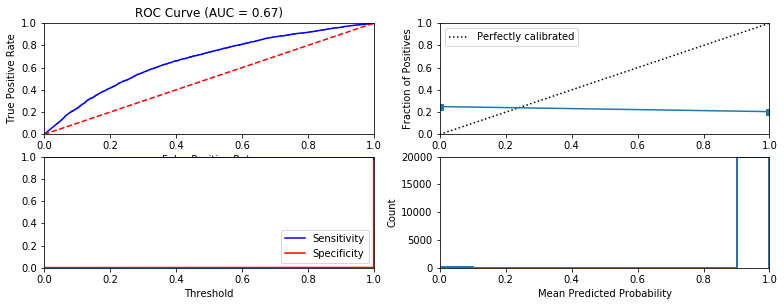


Similarity to LC grade ranking:  0.6766719497249758
Brier score: 0.793590552002484
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.22053333]


In [17]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict, model_name="Naive Bayes Classifier")

### $l_1$ regularized logistic regression

  Model: L1 regularized logistic regression
Fit time: 56.44 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.5102497739039465
Accuracy:  0.79525
              precision    recall  f1-score   support

  No default     0.7987    0.9926    0.8852     15904
     Default     0.5021    0.0288    0.0545      4096

   micro avg     0.7953    0.7953    0.7953     20000
   macro avg     0.6504    0.5107    0.4698     20000
weighted avg     0.7380    0.7953    0.7151     20000



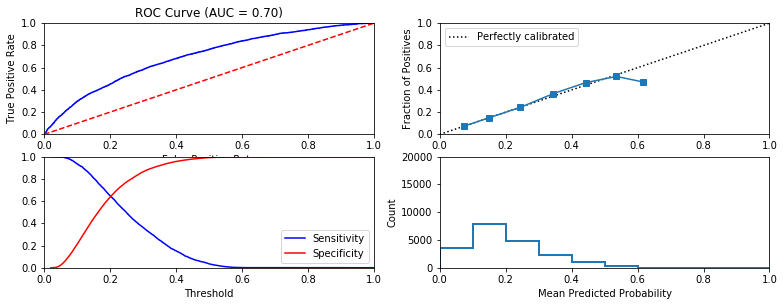


Similarity to LC grade ranking:  0.6917245761743395
Brier score: 0.14957318141360365
Were parameters on edge? : False
Score variations around CV search grid : 0.04167013917827414
[0.79986667 0.79993333 0.79983333 0.7998     0.7996    ]


In [18]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C': [0.01, 0.1, 1, 10, 100]}

l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters, 'L1 regularized logistic regression')

### $l_2$ regularized logistic regression

  Model: L2 regularized logistic regression
Fit time: 3.99 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.5058543728978377
Accuracy:  0.7954
              precision    recall  f1-score   support

  No default     0.7996    0.9911    0.8851     15904
     Default     0.5070    0.0354    0.0662      4096

   micro avg     0.7954    0.7954    0.7954     20000
   macro avg     0.6533    0.5133    0.4756     20000
weighted avg     0.7397    0.7954    0.7174     20000



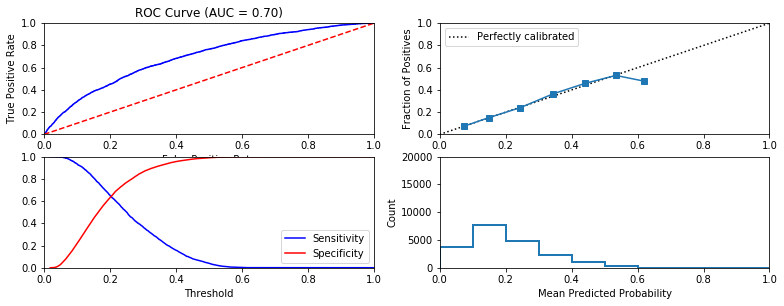


Similarity to LC grade ranking:  0.6943152647520213
Brier score: 0.14943953716504435
Were parameters on edge? : False
Score variations around CV search grid : 0.0749781313783536
[0.79993333 0.80023333 0.79996667 0.7998     0.79963333]


In [29]:
## Train and test a l_2 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.01, 0.1, 1, 10, 100]}

l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters, 'L2 regularized logistic regression')

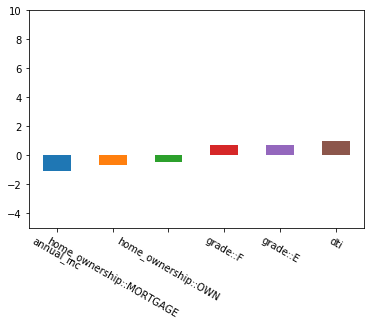

In [30]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision tree
Fit time: 5.65 seconds
Optimal parameters:
{'criterion': 'entropy', 'max_depth': 4}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7952
              precision    recall  f1-score   support

  No default     0.7952    1.0000    0.8859     15904
     Default     0.0000    0.0000    0.0000      4096

   micro avg     0.7952    0.7952    0.7952     20000
   macro avg     0.3976    0.5000    0.4430     20000
weighted avg     0.6323    0.7952    0.7045     20000



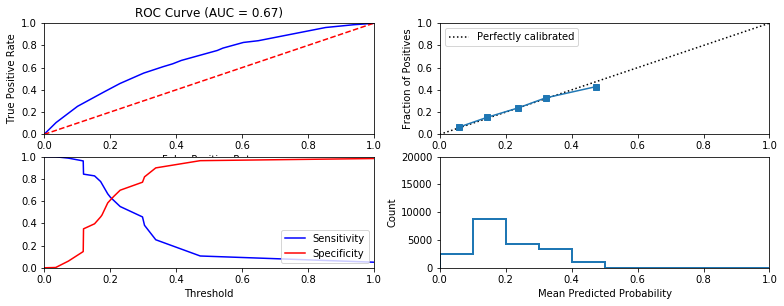


Similarity to LC grade ranking:  0.7243212567484273
Brier score: 0.15314423417449807
Were parameters on edge? : True
Score variations around CV search grid : 2.3485733355581564
[0.79843333 0.79546667 0.79176667 0.78683333 0.7803     0.79906667
 0.79843333 0.79526667 0.7929     0.78763333]


In [22]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8]}

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters, 'Decision tree')

### Random forest

  Model: Random forest
Fit time: 1111.17 seconds
Optimal parameters:
{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}

Accuracy-maximizing threshold was: 0.3850274843390068
Accuracy:  0.7931
              precision    recall  f1-score   support

  No default     0.8096    0.9674    0.8815     15904
     Default     0.4789    0.1165    0.1874      4096

   micro avg     0.7931    0.7931    0.7931     20000
   macro avg     0.6442    0.5419    0.5344     20000
weighted avg     0.7418    0.7931    0.7393     20000



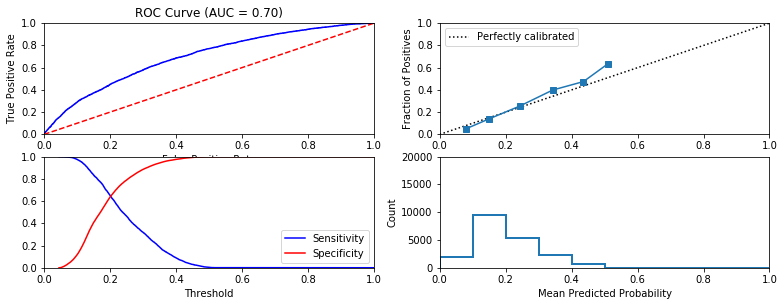


Similarity to LC grade ranking:  0.7381550940855796
Brier score: 0.15018348238667764
Were parameters on edge? : True
Score variations around CV search grid : 0.0749625187406353
[0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.79986667 0.80003333 0.7999     0.7999     0.79986667 0.79986667
 0.8004     0.80016667 0.80026667 0.80006667 0.7999     0.79986667
 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.7999     0.7999     0.7998     0.79983333 0.79986667 0.79986667
 0.8        0.79986667 0.80016667 0.80006667 0.79986667 0.79986667]


In [23]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()
cv_parameters = {'n_estimators': [200, 500],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [4,5,6,7,8],
                'criterion' :['gini', 'entropy']}

random_forest = fit_classification(random_forest, data_dict, cv_parameters, 'Random forest')

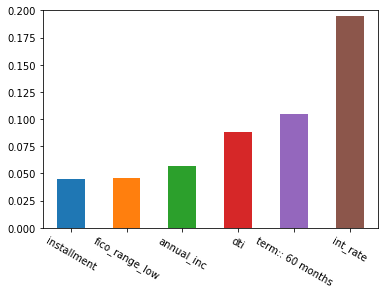

In [24]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: Multi-layer perceptron
Fit time: 2325.47 seconds
Optimal parameters:
{'alpha': 0.01, 'hidden_layer_sizes': 5, 'max_iter': 500, 'solver': 'lbfgs'}

Accuracy-maximizing threshold was: 0.4990437177304169
Accuracy:  0.7932
              precision    recall  f1-score   support

  No default     0.8023    0.9820    0.8831     15904
     Default     0.4625    0.0603    0.1067      4096

   micro avg     0.7932    0.7932    0.7932     20000
   macro avg     0.6324    0.5211    0.4949     20000
weighted avg     0.7327    0.7932    0.7241     20000



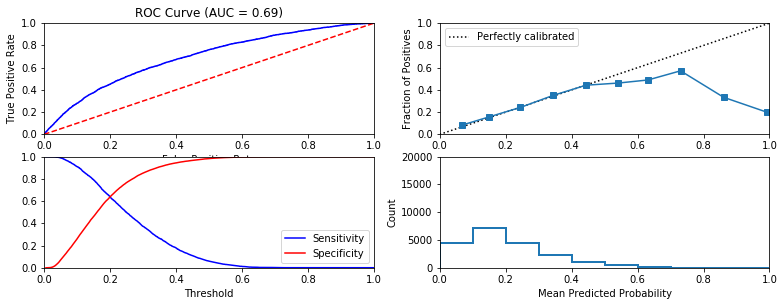


Similarity to LC grade ranking:  0.6509952170711207
Brier score: 0.1508397366725284
Were parameters on edge? : True
Score variations around CV search grid : 0.947017104714233
[0.79576667 0.79816667 0.7958     0.7962     0.79613333 0.79693333
 0.79726667 0.79553333 0.79646667 0.79656667 0.79583333 0.79523333
 0.7962     0.79333333 0.79643333 0.79233333 0.79213333 0.79373333
 0.79333333 0.7932     0.79476667 0.799      0.79863333 0.79816667
 0.7954     0.7978     0.79603333 0.79596667 0.7961     0.79646667
 0.7944     0.79636667 0.79636667 0.79496667 0.7956     0.79586667
 0.79466667 0.79596667 0.79443333 0.7928     0.79453333 0.7923
 0.7975     0.79803333 0.79643333 0.7966     0.7966     0.7963
 0.7965     0.79836667 0.79746667 0.79546667 0.7972     0.79706667
 0.7955     0.7953     0.7937     0.79226667 0.79466667 0.79426667
 0.79303333 0.79296667 0.7931     0.79703333 0.79703333 0.7981
 0.79773333 0.79783333 0.7961     0.7948     0.7972     0.79643333
 0.7939     0.79463333 0.7941   

In [25]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
cv_parameters = {'solver': ['lbfgs'], 
                 'max_iter': [500,1000,1500], 
                 'alpha': 10.0 ** -np.arange(1, 7), 
                 'hidden_layer_sizes':np.arange(5, 12)}

mlp = fit_classification(mlp, data_dict, cv_parameters, 'Multi-layer perceptron')

## Train and Test logistic regression model with features derived by LendingClub

  Model: l1-regularized with lendingClub-defined feature
Fit time: 0.72 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7952
              precision    recall  f1-score   support

  No default     0.7952    1.0000    0.8859     15904
     Default     0.0000    0.0000    0.0000      4096

   micro avg     0.7952    0.7952    0.7952     20000
   macro avg     0.3976    0.5000    0.4430     20000
weighted avg     0.6323    0.7952    0.7045     20000



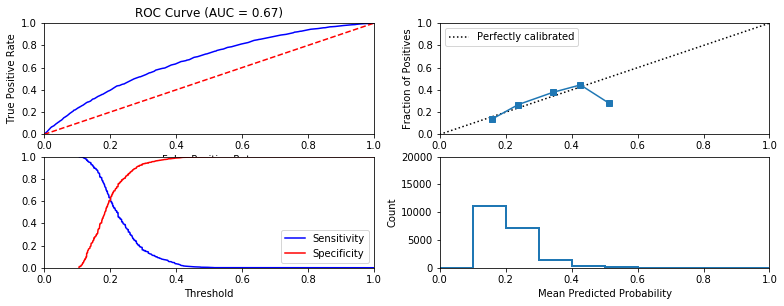


Similarity to LC grade ranking:  0.8551684780693735
Brier score: 0.15502252058263788
Were parameters on edge? : True
Score variations around CV search grid : 0.34172362060342404
[0.79986667 0.7976     0.7973     0.79713333 0.79713333]


In [31]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = 'int_rate'

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C': [0.01, 0.1, 1, 10, 100]}
lc1_only_logistic = fit_classification(lc1_only_logistic, data_dict, cv_parameters, 'l1-regularized with lendingClub-defined feature')

  Model: l2-regularized with lendingClub-defined feature
Fit time: 0.37 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7952
              precision    recall  f1-score   support

  No default     0.7952    1.0000    0.8859     15904
     Default     0.0000    0.0000    0.0000      4096

   micro avg     0.7952    0.7952    0.7952     20000
   macro avg     0.3976    0.5000    0.4430     20000
weighted avg     0.6323    0.7952    0.7045     20000



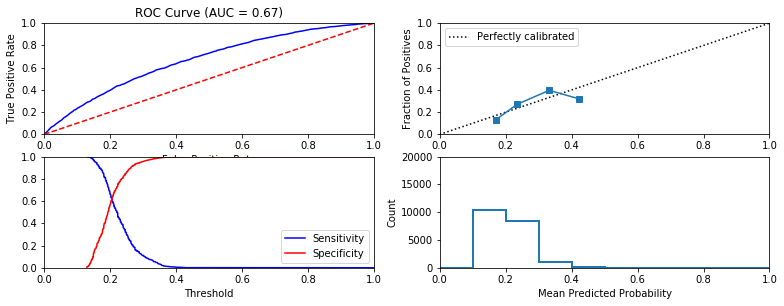


Similarity to LC grade ranking:  0.8551684780693735
Brier score: 0.15611955963189783
Were parameters on edge? : True
Score variations around CV search grid : 0.34589098183029476
[0.79986667 0.7978     0.7971     0.79713333 0.79713333]


In [32]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.01, 0.1, 1, 10, 100]}

lc2_only_logistic = fit_classification(lc2_only_logistic, data_dict, cv_parameters, 'l2-regularized with lendingClub-defined feature')

## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [ ]:
## define your set of features to use in different models
your_features = ['id', 'loan_amnt', 'funded_amnt', 'term', 'emp_length',
'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status',
'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec',
'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
'last_pymnt_d', 'recoveries']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

  Model: Naive Bayes Classifier
Fit time: 0.39 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.7952
              precision    recall  f1-score   support

  No default     0.7952    1.0000    0.8859     15904
     Default     0.0000    0.0000    0.0000      4096

   micro avg     0.7952    0.7952    0.7952     20000
   macro avg     0.3976    0.5000    0.4430     20000
weighted avg     0.6323    0.7952    0.7045     20000



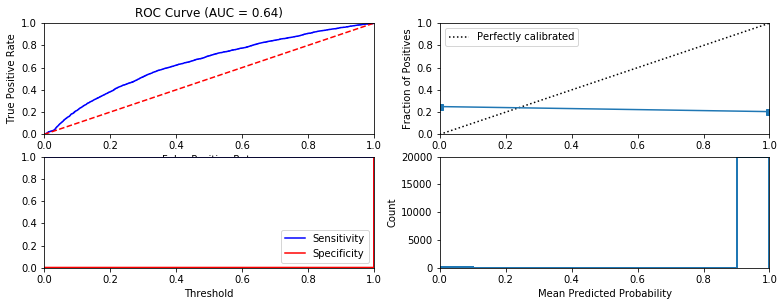


Similarity to LC grade ranking:  0.39342097759937605
Brier score: 0.7935993608856232
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.2065]


In [34]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict, model_name="Naive Bayes Classifier")

  Model: L1 regularized logistic regression
Fit time: 57.7 seconds
Optimal parameters:
{'C': 10}

Accuracy-maximizing threshold was: 0.4989519369270923
Accuracy:  0.79605
              precision    recall  f1-score   support

  No default     0.8006    0.9902    0.8853     15904
     Default     0.5258    0.0422    0.0782      4096

   micro avg     0.7961    0.7961    0.7960     20000
   macro avg     0.6632    0.5162    0.4818     20000
weighted avg     0.7443    0.7961    0.7200     20000



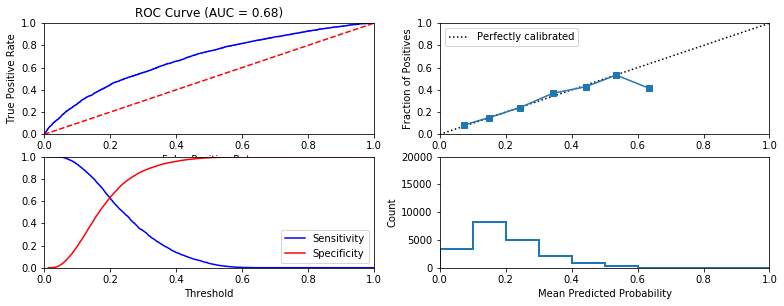


Similarity to LC grade ranking:  0.47196708593006986
Brier score: 0.1513779498777021
Were parameters on edge? : False
Score variations around CV search grid : 0.08327781479014461
[0.79986667 0.8        0.80036667 0.80053333 0.80053333]


In [33]:
## Train and test a l_1 regularized logistic regression classifier

l1_afterRemoving_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'C': [0.01, 0.1, 1, 10, 100]}

l1_afterRemoving_logistic = fit_classification(l1_afterRemoving_logistic, data_dict, cv_parameters, 'L1 regularized logistic regression')

  Model: L2 regularized logistic regression
Fit time: 3.84 seconds
Optimal parameters:
{'C': 10}

Accuracy-maximizing threshold was: 0.49891565118675163
Accuracy:  0.79605
              precision    recall  f1-score   support

  No default     0.8006    0.9901    0.8853     15904
     Default     0.5257    0.0425    0.0786      4096

   micro avg     0.7961    0.7961    0.7960     20000
   macro avg     0.6631    0.5163    0.4820     20000
weighted avg     0.7443    0.7961    0.7201     20000



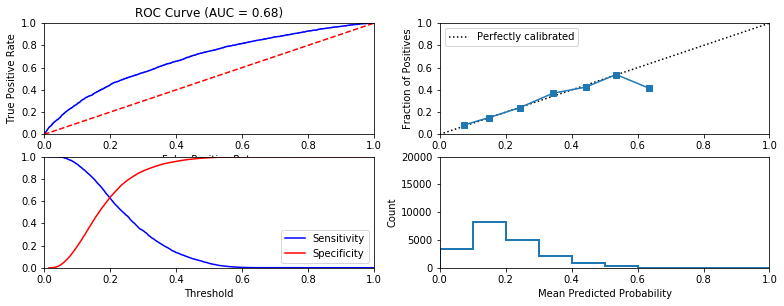


Similarity to LC grade ranking:  0.4718339320660056
Brier score: 0.1514015137238221
Were parameters on edge? : False
Score variations around CV search grid : 0.06662225183210459
[0.8002     0.8        0.80033333 0.80053333 0.8005    ]


In [35]:
## Train and test a l_2 regularized logistic regression classifier

l2_afterRemoving_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.01, 0.1, 1, 10, 100]}

l2_afterRemoving_logistic = fit_classification(l2_afterRemoving_logistic, data_dict, cv_parameters, 'L2 regularized logistic regression')

  Model: Decision tree
Fit time: 4.45 seconds
Optimal parameters:
{'criterion': 'gini', 'max_depth': 4}

Accuracy-maximizing threshold was: 0.5342465753424658
Accuracy:  0.7952
              precision    recall  f1-score   support

  No default     0.7952    1.0000    0.8859     15904
     Default     0.0000    0.0000    0.0000      4096

   micro avg     0.7952    0.7952    0.7952     20000
   macro avg     0.3976    0.5000    0.4430     20000
weighted avg     0.6323    0.7952    0.7045     20000



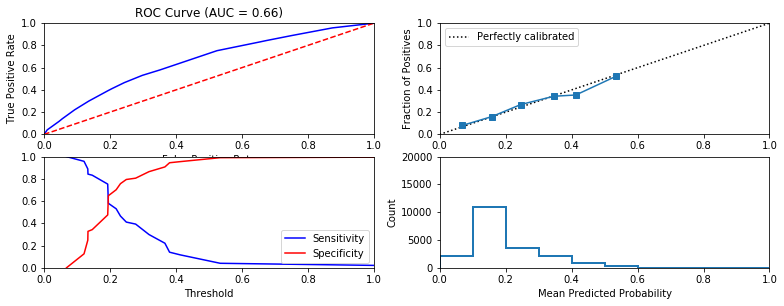


Similarity to LC grade ranking:  0.4280760263928034
Brier score: 0.1542066364636666
Were parameters on edge? : True
Score variations around CV search grid : 1.4294049008167982
[0.79986667 0.79776667 0.79493333 0.79316667 0.78843333 0.79986667
 0.79826667 0.79586667 0.79363333 0.79153333]


In [36]:
## Train and test a decision tree classifier

decision_tree_afterRemoving = DecisionTreeClassifier()
cv_parameters = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8]}

decision_tree_afterRemoving = fit_classification(decision_tree_afterRemoving, data_dict, cv_parameters, 'Decision tree')

  Model: Random forest
Fit time: 993.47 seconds
Optimal parameters:
{'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500}

Accuracy-maximizing threshold was: 0.3278127110852844
Accuracy:  0.78825
              precision    recall  f1-score   support

  No default     0.8135    0.9520    0.8773     15904
     Default     0.4499    0.1523    0.2276      4096

   micro avg     0.7883    0.7883    0.7883     20000
   macro avg     0.6317    0.5522    0.5525     20000
weighted avg     0.7390    0.7883    0.7442     20000



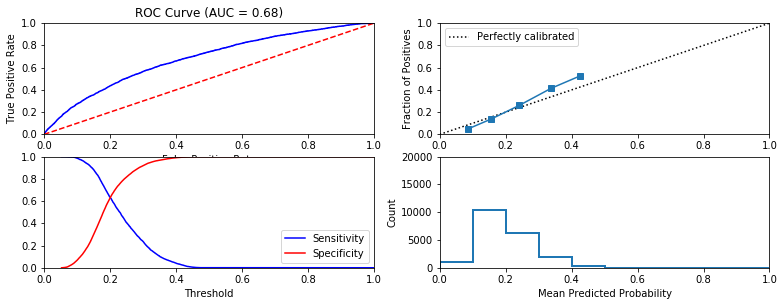


Similarity to LC grade ranking:  0.4727012299234776
Brier score: 0.15251805571450186
Were parameters on edge? : True
Score variations around CV search grid : 0.025000000000011124
[0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.79986667 0.79986667 0.7999     0.79986667 0.79986667 0.79986667
 0.79986667 0.79983333 0.7998     0.8        0.7999     0.79986667
 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667 0.79986667
 0.79993333 0.7999     0.79996667 0.7999     0.79986667 0.79986667]


In [37]:
## Train and test a random forest classifier

random_forest_afterRemoving = RandomForestClassifier()
cv_parameters = {'n_estimators': [200, 500],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [4,5,6,7,8],
                'criterion' :['gini', 'entropy']}

random_forest_afterRemoving = fit_classification(random_forest_afterRemoving, data_dict, cv_parameters, 'Random forest')

  Model: Multi-layer perceptron
Fit time: 2165.7 seconds
Optimal parameters:
{'alpha': 0.1, 'hidden_layer_sizes': 5, 'max_iter': 1000, 'solver': 'lbfgs'}

Accuracy-maximizing threshold was: 0.4796866493488442
Accuracy:  0.79525
              precision    recall  f1-score   support

  No default     0.8035    0.9830    0.8842     15904
     Default     0.5009    0.0664    0.1173      4096

   micro avg     0.7953    0.7953    0.7953     20000
   macro avg     0.6522    0.5247    0.5007     20000
weighted avg     0.7415    0.7953    0.7271     20000



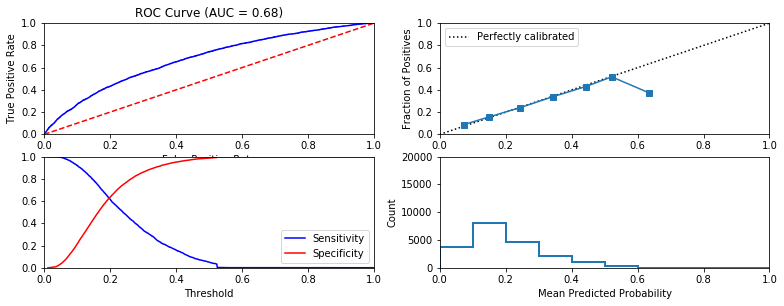


Similarity to LC grade ranking:  0.4585305017087969
Brier score: 0.15194296688188733
Were parameters on edge? : True
Score variations around CV search grid : 0.9461092818738729
[0.79823333 0.79976667 0.7972     0.79746667 0.79786667 0.79823333
 0.7987     0.79713333 0.79613333 0.79886667 0.79596667 0.79613333
 0.798      0.79693333 0.7969     0.79556667 0.79606667 0.7943
 0.79433333 0.79546667 0.7945     0.79733333 0.79806667 0.79833333
 0.7977     0.7979     0.7979     0.7967     0.79893333 0.79713333
 0.79476667 0.79836667 0.79673333 0.79806667 0.79563333 0.7967
 0.79573333 0.79703333 0.79503333 0.79603333 0.7948     0.7922
 0.79893333 0.79843333 0.79866667 0.79806667 0.79766667 0.79763333
 0.798      0.7972     0.79583333 0.79716667 0.79723333 0.7956
 0.79556667 0.79673333 0.79666667 0.79453333 0.79426667 0.7951
 0.7967     0.7955     0.79463333 0.79936667 0.7982     0.7983
 0.79786667 0.79756667 0.79733333 0.79803333 0.7982     0.79633333
 0.79766667 0.79633333 0.79596667 0.796766

In [38]:
## Train and test a multi-layer perceptron classifier

mlp_afterRemoving = MLPClassifier()
cv_parameters = {'solver': ['lbfgs'], 
                 'max_iter': [500,1000,1500], 
                 'alpha': 10.0 ** -np.arange(1, 7), 
                 'hidden_layer_sizes':np.arange(5, 12)}

mlp_afterRemoving = fit_classification(mlp_afterRemoving, data_dict, cv_parameters, 'Multi-layer perceptron')

## Time stability test of YOURMODEL

  Model: L2 trained on 2010 model
Fit time: 0.1 seconds
Optimal parameters:
{'C': 1}

Accuracy-maximizing threshold was: 0.35736001777016946
Accuracy:  0.8592857142857143
              precision    recall  f1-score   support

  No default     0.8746    0.9794    0.9240      6117
     Default     0.1600    0.0272    0.0465       883

   micro avg     0.8593    0.8593    0.8593      7000
   macro avg     0.5173    0.5033    0.4853      7000
weighted avg     0.7845    0.8593    0.8133      7000



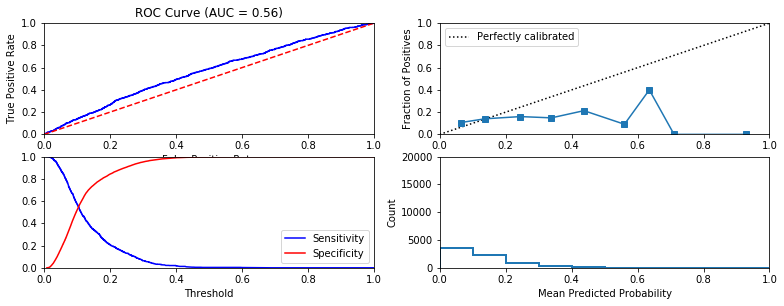


Similarity to LC grade ranking:  0.32398341194137026
Brier score: 0.1139158852224022
Were parameters on edge? : False
Score variations around CV search grid : 0.6808510638297899
[0.87677371 0.87677371 0.87752054 0.87528006 0.87154593]
  Model: L2 trained on 2016 model
Fit time: 0.74 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.527403038921784
Accuracy:  0.8657142857142858
              precision    recall  f1-score   support

  No default     0.8707    0.9931    0.9279      6087
     Default     0.2632    0.0164    0.0309       913

   micro avg     0.8657    0.8657    0.8657      7000
   macro avg     0.5669    0.5048    0.4794      7000
weighted avg     0.7914    0.8657    0.8109      7000



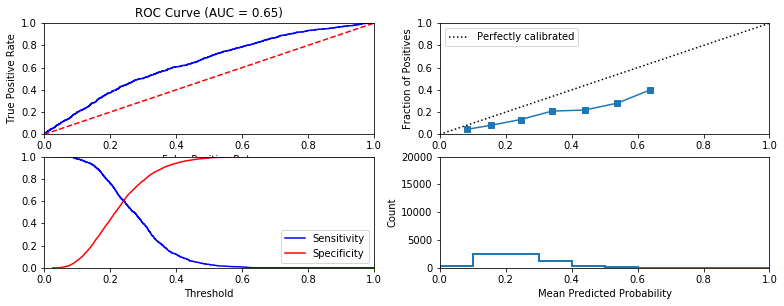


Similarity to LC grade ranking:  0.40856253098558704
Brier score: 0.12316227063468928
Were parameters on edge? : False
Score variations around CV search grid : 0.13179089178503453
[0.75777778 0.75877778 0.75788889 0.758      0.75811111]


{'model': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.35706269, 0.44000576, 0.18039316, ..., 0.12220556, 0.27647826,
        0.20278231])}

In [51]:
## Define the time window of your train and test data
start_date_train = datetime.date(2010,1,1)
end_date_train = datetime.date(2010,12,31)
start_date_test = datetime.date(2017,1,1)
end_date_test = datetime.date(2017,12,31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
YOURMODEL = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.01, 0.1, 1, 10, 100]}

fit_classification(YOURMODEL, data_dict_test, cv_parameters, 'L2 trained on 2010 model')


start_date_train = datetime.date(2016,1,1)
end_date_train = datetime.date(2016,12,31)
start_date_test = datetime.date(2017,1,1)
end_date_test = datetime.date(2017,12,31)


data_dict_test_2016 = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)



fit_classification(YOURMODEL, data_dict_test_2016, cv_parameters, 'L2 trained on 2016 model')


## Train and test YOURMODEL on the original data

  Model: L1 trained on original data
Fit time: 3.73 seconds
Optimal parameters:
{'C': 10}

Accuracy-maximizing threshold was: 0.49891565118675163
Accuracy:  0.79605
              precision    recall  f1-score   support

  No default     0.8006    0.9901    0.8853     15904
     Default     0.5257    0.0425    0.0786      4096

   micro avg     0.7961    0.7961    0.7960     20000
   macro avg     0.6631    0.5163    0.4820     20000
weighted avg     0.7443    0.7961    0.7201     20000



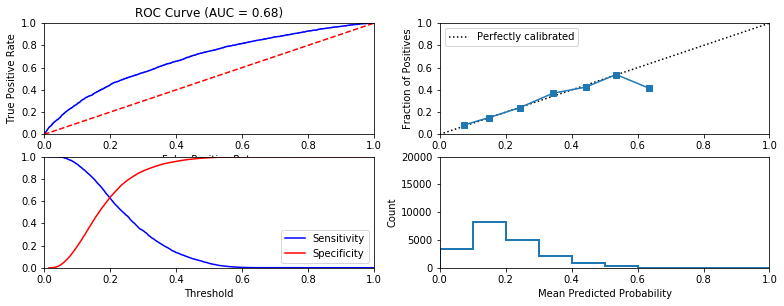


Similarity to LC grade ranking:  0.4718339320660056
Brier score: 0.1514015137238221
Were parameters on edge? : False
Score variations around CV search grid : 0.06662225183210459
[0.8002     0.8        0.80033333 0.80053333 0.8005    ]


{'model': LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.3589209 , 0.16218217, 0.22515346, ..., 0.13996436, 0.12512301,
        0.15537972])}

In [52]:
YOURMODEL = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.01, 0.1, 1, 10, 100]}

fit_classification(YOURMODEL, data_dict, cv_parameters, 'L1 trained on original data')


## Test regression models

In [53]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [62]:
## First, trying l1 regularized linear regression with hyper-parameters

cv_parameters = {'alpha': [0.01, 0.1, 1, 10, 100]}
reg_lasso = linear_model.Lasso()
reg_lasso = fit_regression(reg_lasso, data_dict, cv_parameters, model_name="L1 regularized linear regression")

  Model: L1 regularized linear regression  Return column: ret_PESS
Fit time: 0.68 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: -8.13488810165186e-05
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.1101577 -0.1101577 -0.1101577 -0.1101577 -0.1101577]
  Model: L1 regularized linear regression  Return column: ret_OPT
Fit time: 0.58 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: -5.644941678761839e-05
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.03264311 -0.03264311 -0.03264311 -0.03264311 -0.03264311]
  Model: L1 regularized linear regression  Return column: ret_INTa
Fit time: 0.56 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: -7.687353155172438e-05
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.09979938 -0.09979938 -0.09979938 -0.099799

### $l_2$ regularized linear regressor

In [63]:
## trying l2 regularized linear regression with hyper-parameters
cv_parameters = {'alpha': [0.01, 0.1, 1, 10, 100]}
reg_ridge = linear_model.Ridge()
reg_ridge = fit_regression(reg_ridge, data_dict, cv_parameters, model_name="L2 regularized linear regression")

  Model: L2 regularized linear regression  Return column: ret_PESS
Fit time: 0.57 seconds
Optimal parameters:
{'alpha': 10}

Testing r2 score: 0.030769724085067507
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -1.7036302973306987
All test scores : [-0.08247703 -0.08232991 -0.08200015 -0.08187666 -0.08327153]
  Model: L2 regularized linear regression  Return column: ret_OPT
Fit time: 0.49 seconds
Optimal parameters:
{'alpha': 10}

Testing r2 score: 0.014428665010733255
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -1.310900611079911
All test scores : [-0.02471172 -0.02464503 -0.02447414 -0.02439197 -0.0245101 ]
  Model: L2 regularized linear regression  Return column: ret_INTa
Fit time: 0.51 seconds
Optimal parameters:
{'alpha': 10}

Testing r2 score: 0.03483552420104008
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -1.3338966491101265
All test scores : [-0.07

### Multi-layer perceptron regressor

In [66]:
## trying multi-layer perceptron regression with hyper-parameters
reg_mlp = MLPRegressor()
cv_parameters = { 'max_iter': [500,1000,1500], 
                 'alpha': 10.0 ** -np.arange(1, 7), 
                 'hidden_layer_sizes':np.arange(5, 12),
                'activation': ["logistic", "relu", "tanh"]
                }

reg_mlp = fit_regression(reg_mlp, data_dict, cv_parameters, model_name = 'Multi-layer peceptron regressor')

  Model: Multi-layer peceptron regressor  Return column: ret_PESS
Fit time: 942.12 seconds
Optimal parameters:
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 10, 'max_iter': 1500}

Testing r2 score: 0.011958724891205308
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -339.02112514894344
All test scores : [-0.11531067 -0.10389493 -0.13000635 -0.09140932 -0.07791391 -0.12961912
 -0.08021501 -0.08848064 -0.10520377 -0.10853537 -0.08227254 -0.112785
 -0.0642927  -0.08834546 -0.07454674 -0.06018454 -0.07144125 -0.11843969
 -0.07844656 -0.07147805 -0.12815238 -0.09802139 -0.15659356 -0.11607984
 -0.10313838 -0.09181548 -0.08606701 -0.09056    -0.07778175 -0.10987931
 -0.07173474 -0.07761169 -0.07096962 -0.07845996 -0.07937345 -0.1130617
 -0.09796124 -0.06370626 -0.10254635 -0.06886355 -0.1213066  -0.09506529
 -0.11401576 -0.08564963 -0.07729447 -0.12350705 -0.09609217 -0.09725978
 -0.09339639 -0.09597099 -0.07961556 -0.07639492 -0.075553

  Model: Multi-layer peceptron regressor  Return column: ret_INTa
Fit time: 870.41 seconds
Optimal parameters:
{'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': 11, 'max_iter': 1500}

Testing r2 score: 0.03182784534290728
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -564.6801084857697
All test scores : [-0.09565536 -0.07558913 -0.08184089 -0.08895704 -0.11027691 -0.09158076
 -0.09968766 -0.09503838 -0.0904316  -0.09607698 -0.07382601 -0.08880232
 -0.09558469 -0.05675481 -0.08880527 -0.08261664 -0.05249218 -0.08759815
 -0.0954358  -0.09079114 -0.09421344 -0.11590591 -0.09732569 -0.08243593
 -0.09683976 -0.11758821 -0.11690504 -0.07258664 -0.07529872 -0.0984267
 -0.06791245 -0.08258073 -0.08561127 -0.11196927 -0.07558379 -0.07642633
 -0.08922255 -0.06021515 -0.09489324 -0.08659149 -0.08315743 -0.06219491
 -0.1285367  -0.10610932 -0.09052087 -0.10685841 -0.12510101 -0.08364642
 -0.17441656 -0.07641105 -0.13166097 -0.09918375 -0.09613902 

### Random forest regressor

In [68]:
## trying random forest regression with hyper-parameters
reg_rf = RandomForestRegressor()
cv_parameters = {'n_estimators': [200, 500],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [4,5,6,7,8],
               }

reg_rf = fit_regression(reg_rf, data_dict, cv_parameters, model_name = 'Random forest regressor')

  Model: Random forest regressor  Return column: ret_PESS
Fit time: 946.07 seconds
Optimal parameters:
{'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}

Testing r2 score: 0.03501358332420512
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -18.42196066511392
All test scores : [-0.08594305 -0.08606457 -0.09245539 -0.09205842 -0.09423057 -0.09387754
 -0.0828148  -0.08280217 -0.08950886 -0.08898648 -0.09079057 -0.09071603
 -0.08053998 -0.08099935 -0.08587222 -0.08634091 -0.08789548 -0.08811698
 -0.07994137 -0.08006379 -0.08349632 -0.08386621 -0.08577107 -0.08489956
 -0.07976568 -0.07957187 -0.08209088 -0.08204096 -0.0842712  -0.08319013]
  Model: Random forest regressor  Return column: ret_OPT
Fit time: 915.18 seconds
Optimal parameters:
{'max_depth': 7, 'max_features': 'auto', 'n_estimators': 500}

Testing r2 score: 0.01742535591512928
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -29.5281376794

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [136]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans][ret_col]

            ## Find the average return for these loans
            ret_test = pf_test.mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans][ret_col]

            ## Find their return
            ret_test = pf_test.mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans][ret_col]

            ## Find the average return for these loans
            ret_test = pf_test.mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans][colname]

            ## Find their return
            ret_test = pf_test.mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [118]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_rand = test_investments(data_dict, regressor=reg_rf, strategy=test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

strategy: Random
ret_PESS: -0.0006661741833414125
ret_OPT: 0.04249104177930468
ret_INTa: 0.02113390716991577
ret_INTb: 0.05690932244231311


In [137]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)
strat_def = test_investments(data_dict,classifier=random_forest_afterRemoving, regressor=reg_rf, strategy=test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_def[ret_col]['average return']))

strategy: Default-based
ret_PESS: 0.02372171991049014
ret_OPT: 0.027101822282708632
ret_INTa: 0.035266989812566395
ret_INTb: 0.0295142851462565


In [138]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_ret = test_investments(data_dict, regressor=reg_rf, strategy=test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))

strategy: Return-based
ret_PESS: 0.0279942039399542
ret_OPT: 0.04087506273348844
ret_INTa: 0.019709080663124483
ret_INTb: 0.059315392017147764


In [142]:
reg_separate = RandomForestRegressor()
cv_parameters = {'n_estimators': [200, 500],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [4,5,6,7,8],
               }

reg_separate = fit_regression(reg_separate, data_dict, cv_parameters, model_name = 'Random forest', separate=True)

  Model: Random forest  Return column: ret_PESS
Fit time: 938.4 seconds
Optimal parameters:
model_0: {'max_depth': 7, 'max_features': 'auto', 'n_estimators': 200} model_1 {'max_depth': 6, 'max_features': 'auto', 'n_estimators': 500}

Testing r2 scores:
model_0: 0.027359723080260134
model_1: 0.09912099518347062
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -8.768985358097305
All test scores : [-0.15003312 -0.15036144 -0.15911596 -0.15905503 -0.16134635 -0.16060944
 -0.14981533 -0.14877821 -0.15576894 -0.15641189 -0.15769789 -0.15817045
 -0.14890202 -0.14978326 -0.15385665 -0.15324137 -0.15449954 -0.1554836
 -0.14833856 -0.1495994  -0.15046178 -0.15084533 -0.15236924 -0.1529916
 -0.15033309 -0.14929482 -0.14951405 -0.14875389 -0.15043023 -0.15019482]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -63.322185884179916
All test scores : [-0.08247711 -0.0810052  -0.1214109  -0.12163055 -0.12877339 -0.1

In [143]:
print('strategy:',test_strategy)
strat_defret = test_investments(data_dict, classifier=random_forest_afterRemoving, regressor=reg_separate, strategy=test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))

strategy: Default-return-based
ret_PESS: 0.0251574017352351
ret_OPT: 0.04137579449647093
ret_INTa: 0.021914533392208564
ret_INTb: 0.05116593895010522


## Sensitivity test of portfolio size

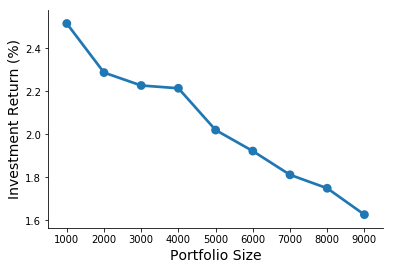

In [144]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict, classifier=random_forest_afterRemoving, regressor=reg_separate, strategy=test_strategy, num_loans=num_loans)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()